In [1]:
%run setup/GpuOptions.ipynb

Enabling memory growth on PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [2]:
import os
import sys

sys.path.append('..')

import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, optimizers, losses
import common.model as m
from common.dataset import Dataset

dataset = Dataset(
    '../dataset/dataset-2022-10-19T22-51-08',
    batch_size=8,
    image_size=(1920, 1080))
classes = dataset.training.class_names
data, _ = next(iter(dataset.training))
shape = data[0].shape
inputs = tf.keras.Input(shape=shape)

def create_model(with_augmentations=False):
    translation_amount = 0.10 if with_augmentations else 0.0
    brightness_amount = 0.05 if with_augmentations else 0.0
    augmentation = [
        layers.RandomTranslation(
            translation_amount,
            translation_amount,
            fill_mode='nearest'
        ),
        layers.RandomBrightness(brightness_amount),
        # Cropping2D parameter are how much to take off of top, bottom, 
        # left and right, not a rectangle of the cropped image
        layers.Cropping2D(cropping=((160, 350), (580, 450))),
    ]
    outputs = m.chained(
        # Augmentations
        *augmentation,
        # Entry Flow
        layers.Conv2D(filters=32, kernel_size=3, strides=2, padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(filters=64, kernel_size=3, padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        m.expand(
            flow=lambda previous_activation, size: layers.add([
                m.chained(
                    m.duplicate(
                        layers=lambda: [
                            layers.Activation('relu'),
                            layers.SeparableConv2D(filters=size, kernel_size=3, padding='same'),
                            layers.BatchNormalization(),
                        ],
                        count=2
                    ),
                    layers.MaxPooling2D(pool_size=3, strides=2, padding='same'),
                )(previous_activation),
                layers.Conv2D(filters=size, kernel_size=1, strides=2, padding='same')(previous_activation),
            ]),
            values=[128, 256, 728],
        ),

        # Middle Flow
        m.expand(
            flow=lambda previous_activation, _: layers.add([
                m.duplicate(
                    layers=lambda: [
                        layers.Activation('relu'),
                        layers.SeparableConv2D(filters=728, kernel_size=3, padding='same'),
                        layers.BatchNormalization(),
                    ],
                    count=3,
                )(previous_activation),
                previous_activation,
            ]),
            values=[0] * 8
        ),

        # Exit Flow
        lambda previous_activation: layers.add([
            m.chained(
                layers.Activation('relu'),
                layers.SeparableConv2D(filters=728, kernel_size=3, padding='same'),
                layers.BatchNormalization(),
                layers.Activation('relu'),
                layers.SeparableConv2D(filters=1024, kernel_size=3, padding='same'),
                layers.BatchNormalization(),
                layers.MaxPooling2D(pool_size=3, strides=2, padding='same'),
            )(previous_activation),
            layers.Conv2D(filters=1024, kernel_size=1, strides=2, padding='same')(previous_activation),
        ]),
        layers.Activation('relu'),
        layers.SeparableConv2D(filters=728, kernel_size=3, padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.SeparableConv2D(filters=1024, kernel_size=3, padding='same'),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling2D(),
        layers.Dense(len(classes), activation='linear'),
        layers.Dropout(0.2),
    )(inputs)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.build(input_shape=(None, *shape))
    model.compile(
        optimizer=optimizers.Adadelta(
            learning_rate=optimizers.schedules.CosineDecayRestarts(
                1.0,
                # Decay over 5 epochs and then restart 
                dataset.training.cardinality().numpy() * 5)),
        loss=losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.05),
        metrics=['accuracy'],
    )
    return model

Found 3106 files belonging to 4 classes.
Using 2485 files for training.
Found 3106 files belonging to 4 classes.
Using 621 files for validation.


In [3]:
from datetime import datetime

model = create_model(with_augmentation=True)
model.fit(
    dataset.training,
    epochs=700,
    verbose=True,
    validation_data=dataset.validation,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(
            'isthemountainout.best.h5',
            monitor='val_loss',
            mode='min',
            save_best_only=True,
            verbose=True),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            mode='min',
            patience=20,
            restore_best_weights=True,
            verbose=True),
        tf.keras.callbacks.TensorBoard(
            log_dir=os.path.join('tensor-logs', 'fit', datetime.now().strftime('%Y%m%d%H%M%S')),
            update_freq=50,
            write_images=True,
            write_graph=True,
            embeddings_freq=10),
    ])

Epoch 1/700
311/311 [==============================] - ETA: 0s - loss: 0.4998 - accuracy: 0.8523
Epoch 1: val_loss improved from inf to 0.67127, saving model to isthemountainout.best.h5
311/311 [==============================] - 132s 384ms/step - loss: 0.4998 - accuracy: 0.8523 - val_loss: 0.6713 - val_accuracy: 0.7649
Epoch 2/700
311/311 [==============================] - ETA: 0s - loss: 0.4608 - accuracy: 0.8720
Epoch 2: val_loss improved from 0.67127 to 0.47266, saving model to isthemountainout.best.h5
311/311 [==============================] - 121s 387ms/step - loss: 0.4608 - accuracy: 0.8720 - val_loss: 0.4727 - val_accuracy: 0.8921
Epoch 3/700
311/311 [==============================] - ETA: 0s - loss: 0.4620 - accuracy: 0.8748
Epoch 3: val_loss improved from 0.47266 to 0.38016, saving model to isthemountainout.best.h5
311/311 [==============================] - 119s 381ms/step - loss: 0.4620 - accuracy: 0.8748 - val_loss: 0.3802 - val_accuracy: 0.9082
Epoch 4/700
311/311 [========

loading model with best weights
Found 3106 files belonging to 4 classes.
Using 2175 files for training.
Found 3106 files belonging to 4 classes.
Using 931 files for validation.


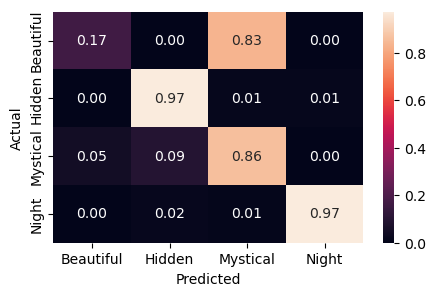

In [4]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

print('loading model with best weights')
model = create_model(with_augmentations=False)
model.load_weights('isthemountainout.best.h5')

dataset = Dataset(
    '../dataset/dataset-2022-10-19T22-51-08',
    batch_size=8,
    image_size=(1920, 1080),
    validation_split=0.3)
validations = dataset.validation
predictions = []
labels = []
for data, label in validations:
  labels.append(tf.argmax(label, axis=1))
  predictions.append(tf.math.argmax(tf.nn.softmax(model.predict(data, verbose=0)), axis=1))
labels = tf.concat(labels, axis=0)
predictions = tf.concat(predictions, axis=0)
cm = confusion_matrix(labels, predictions, labels=list(range(len(dataset.validation.class_names))))
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(5, 3))
sns.heatmap(
  cmn,
  annot=True,
  fmt='.2f',
  xticklabels=dataset.validation.class_names,
  yticklabels=dataset.validation.class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)